## Calculate Level of Maximum divergence (Climo/El Nino/La Nina)

In [45]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import datetime as dt
import numpy as np
import os
import glob as g

from geocat.comp import interp_hybrid_to_pressure
 
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import cm
import matplotlib.colors as colors

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf

from distributed import Client
from ncar_jobqueue import NCARCluster

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

### To Import My Functions ###
import vert_prof_func as mypy
import vert_prof_case_desc as mycase
import importlib


In [46]:
cluster = NCARCluster()
cluster.scale(10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.5:32961,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [49]:
'''
    Data Read Routines
'''

from os.path import exists

def climo_nino_data_read(case_in,seas_in,ave_period,lats,latn):
    
    dir_reanal = '/glade/work/rneale/data/'
#    dir_reanal = '/glade/p/cesm/amwg/amwg_data/obs_data/'
    
    dir_cam = '/glade/p/cgd/amp/people/hannay/amwg/climo/'
    reanals = ['ERA5','MERRA2','CFSR','JRA25','ERAI']
   
    

    seas_in_sampling = [1,2,12]
    
    if case_in in reanals:
        
        is_reanal = True
        
        dir_in = dir_reanal
 # Try single seaona month meanas.
 #       file_in = dir_in+case_in+'/'+case_in+'_'+ave_period+'_'+seas_in+'.nc'
        file_in = dir_in+case_in+'/'+case_in+'_climo.nc'
        
 # If not try a 12 month climo file
 #       if not exists(file_in):
 #       file_in = dir_in+case_in+'_'+seas_in+'_climo.nc'
            
            
    else:
        
        is_reanal = False
        
        dir_in = dir_cam
        sim_names = mycase.mdtf_case_list()
        sim_name = sim_names.loc[case_in]['run name']
        file_in =dir_in+sim_name+'/yrs_1979-2005/'+sim_name+'_'+seas_in+'_climo.nc'
        
    
#    print(file_in)
    
    ds_in = xr.open_dataset(file_in,engine='netcdf4',decode_times = False,decode_cf = True)
    ds_in = ds_in.squeeze()

#    ds_in = ds_in.sel(lat=slice(lats,latn))
#    ds_in = ds_in.sel_points(time=seas_in_sampling)
  
#    print(ds_in.isel(time=slice(seas_in_sampling[0],seas_in_sampling[-1])))
    if case_in in reanals:
        ds_in = ds_in.isel(time=slice(seas_in_sampling[0],seas_in_sampling[-1])).mean(dim='time')
        
    
    
    return ds_in,is_reanal


ERA5
MERRA2


ValueError: Dimensions {'time'} do not exist. Expected one or more of Frozen({'lon': 576, 'lat': 361, 'lev': 42})

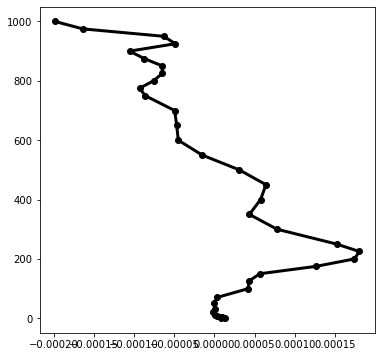

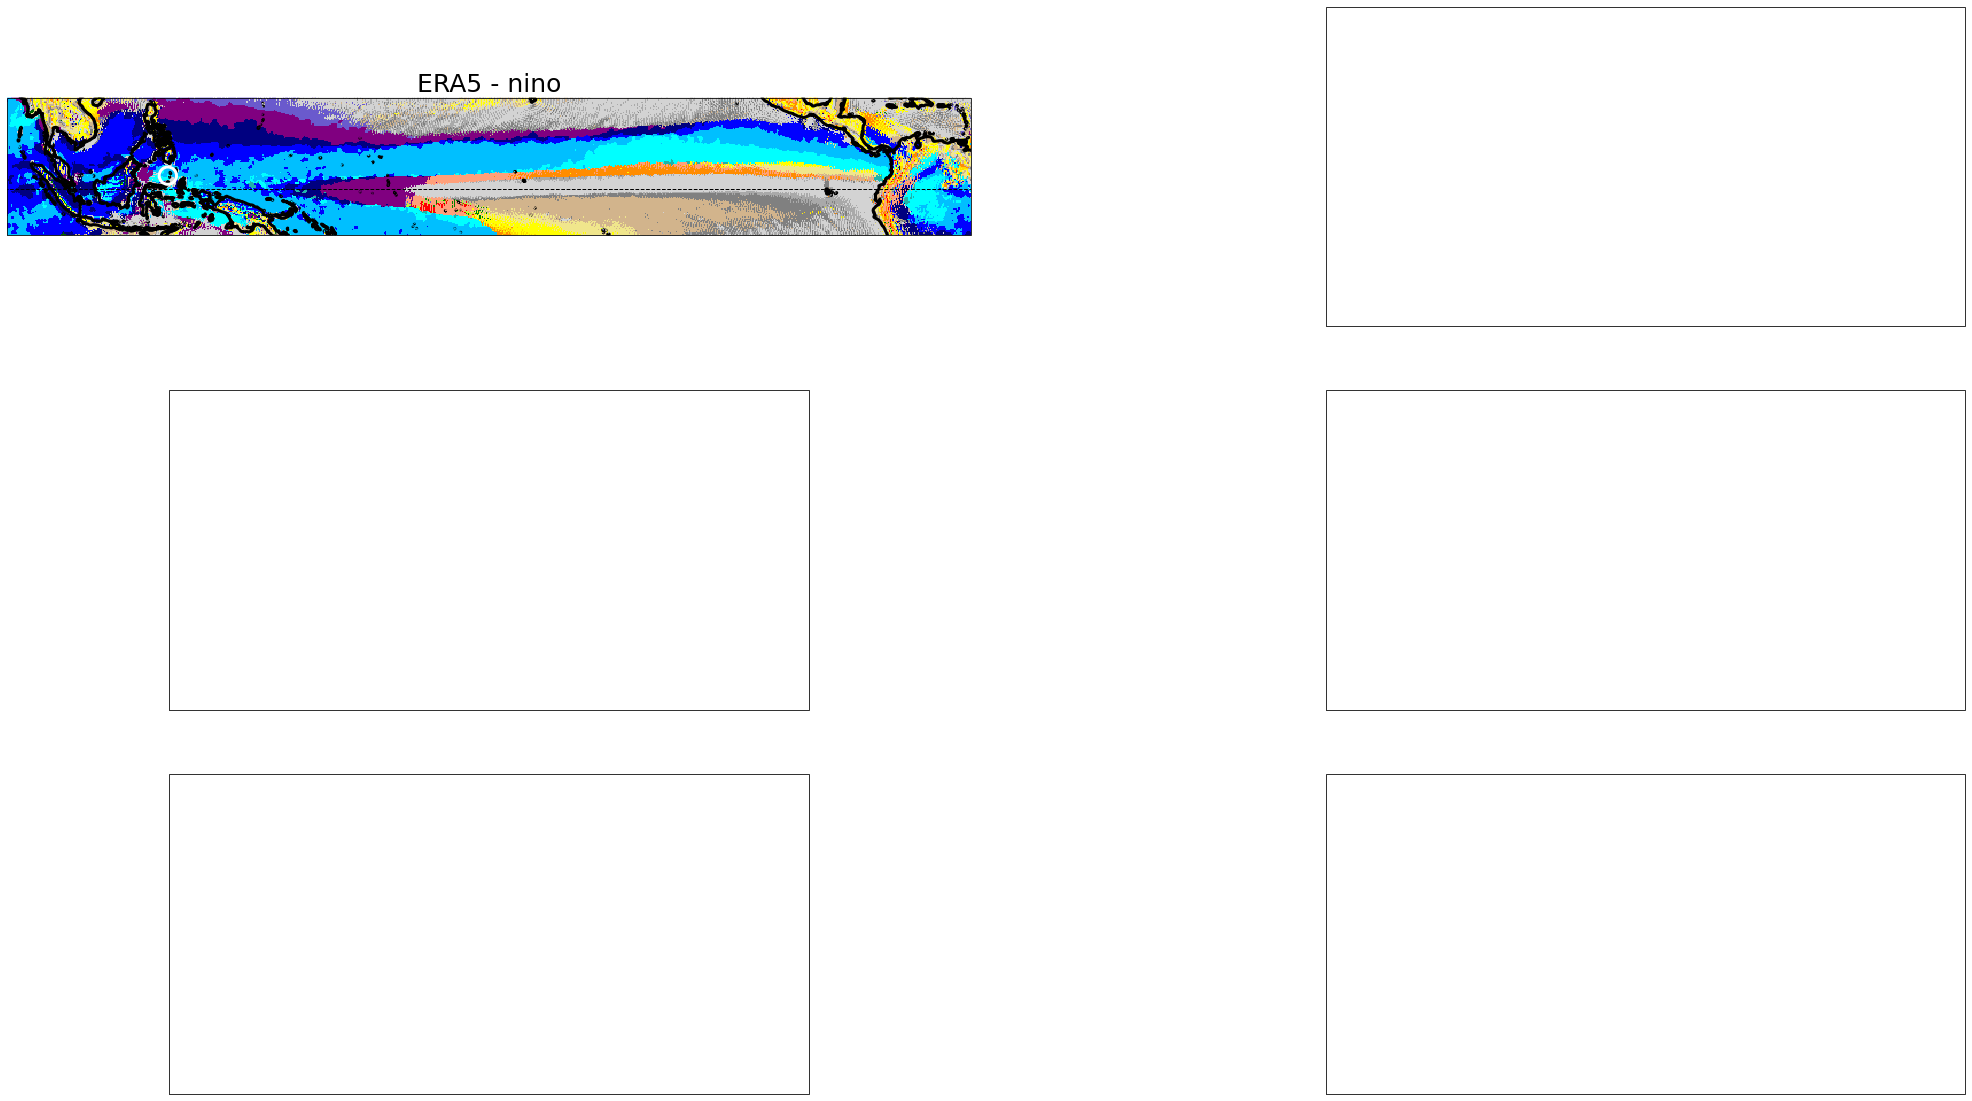

In [51]:
'''
    Input Data Info
'''


cases = ['ERA5','MERRA2','C6','rC5now','CE2','CE1']
#cases = ['ERA5','C6','rC5now','CE2','CE1']

ave_period = 'nino'
season = 'DJF'
var_plot = 'max_div_level'
lats = -10. ; latn = 20.
lonw = 90. ; lone = 300.

vprof_lon = 125. ; vprof_lat = 3.
plevel = '500'
season = 'DJF'
mvar_grab = 'OMEGA' ; ovar_grab = 'OMEGA'

ncases = len(cases)

nrows = 3
ncols = 2

# General settings







# Figure Resources

cc_pc = ccrs.PlateCarree(central_longitude=180)
tcc_pc = ccrs.PlateCarree()


#fig = plt.figure(figsize=(18,6))
#ax2 = plt.axes(projection=tcc_pc)



fig,axs =  plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': cc_pc},
                        figsize=(38,20))
plt.figure(1)
# Set figure background to be transparent not white.

figl,axl = plt.subplots(1,1,figsize=(6,6))
plt.figure(2)


fig.patch.set_facecolor('white') 


pcolors = ['k','r','b','g','m','c']

## Code ##


axs=axs.flatten()

for i,model in enumerate(cases):

    case = cases[i]
    print(case)
    
   

    ''' Grab Dataset '''

    ds_in,is_reanal = climo_nino_data_read(case,season,ave_period,lats,latn)
    var_grab = ovar_grab if is_reanal else mvar_grab
        
    

# Grab coomon variables
    da_in = ds_in[var_grab]

    if var_plot=='OMEGA':
       
        da_in = ds[var_plot]
    
        clevs = np.arange( -0.06,0.06,0.01)
        vscale = 1.
    
    if var_plot=='div':
        da_in = da_in.differentiate("lev")
    
    if var_plot=='max_div_level':
        
        clevs = [1000, 975, 950, 925, 900, 850,  800, 750, 700, 
        600, 500, 450, 400,300, 250, 225,200, 175, 150, 125, 100,50]
     
        
        ## Deriving pressure level omega in CAM
      
        if not is_reanal:                      
            
            da_in_ps = ds_in['PS'] # 2D file

                # Extract the data needed
            
            hyam = ds_in.hyam  # hybrid A coefficient
            hybm = ds_in.hybm  # hybrid B coefficient
            p0 = 100000  # surface reference pressure in Pascals

            # Specify output pressure levels
            new_levels = np.array(clevs)
            new_levels = new_levels * 100  # convert to Pascals

# Interpolate pressure coordinates form hybrid sigma coord
            da_in = interp_hybrid_to_pressure(da_in,
                                  da_in_ps,
                                  hyam,
                                  hybm,
                                  p0=p0,
                                  new_levels=new_levels,
                                  method='log')
            # Swap variable nam
            da_in = da_in.rename({'plev': 'lev'})
            
            # Rescale to mb
            da_in = da_in.assign_coords(lev=0.01*da_in.lev)
           
        # Find divergence and plot
       
        da_in = -da_in.differentiate("lev")
        
        
        plt.figure(2)
        axl.plot(da_in.sel(lat=vprof_lat,lon=vprof_lon,method='nearest'),da_in.lev,marker ='o',lw=3,color=pcolors[i])
            
       
        
#        axl.invert_yaxis()
       
       

      
        
        da_in = da_in.idxmax(dim='lev')
        
    
        

        # Specific Plotting parmas.
     
        
        clevsp = [1008,992,962,938,912,875,825,775,725,650,550,475,425,350,275,232.5,212.5,187,162,132.5,112.5,75,25]
        
        clevsr = clevs
        clevsr.reverse()
        
    
        ccols =  ['lightgray','darkgray','gray','tan','khaki','yellow','gold','darkorange','lightsalmon','red','greenyellow',
                  'green','darkgreen','lightseagreen','cyan','deepskyblue','blue','navy','purple','slateblue','violet','pink']
        ccols.reverse()
        cmap = colors.ListedColormap(ccols)
        

    plt.figure(1)
    axs[i].coastlines(color='black',linewidth=3)
    axs[i].set_extent([lonw, lone, lats,latn], crs=ccrs.PlateCarree())
   
#    da_in.values = np.ma.masked_where(da_in.values > 250., da_in)

    im = da_in.plot.pcolormesh(ax=axs[i], transform=tcc_pc,levels=clevsp,cmap=cmap,rasterized=True,add_colorbar=False)
    axs[i].set_title(case+' - '+ave_period, fontsize=25)
    axs[i].hlines(0., -180, 180., color='black',lw=1,linestyle='--')
    axs[i].scatter(vprof_lon, vprof_lat, marker='o', transform=tcc_pc, facecolors='none', edgecolors="white",s=300,linewidth=3,zorder=2)
    
    

axl.grid(linestyle='--')
axl.set_ylim([1000,10])

axl.set_title('Divergence',fontsize=16)
axl.set_ylabel('mb',fontsize=16) 
axl.set_xlabel('s^-1',fontsize=16) 
axl.vlines(0.,1005,10, linestyle="--",lw=3, color='black')
axl.legend(cases,fontsize=16)


fig.subplots_adjust(bottom=0.25)

clevst = [25.+ cc for cc in clevsr]

cbar_ax = fig.add_axes([0.5, 0.34, 0.01, 0.46])

cbar_ax.set_title('Max Div. \n Pressure (mb)',fontsize=20)
plt.figure(1)
fig.colorbar(im, cax=cbar_ax, orientation="vertical",ticks=clevsr)
cbar_ax.set_yticklabels(clevsr,fontsize=20)
cbar_ax.invert_yaxis()

fig.savefig(case+'_'+ave_period+'_'+season+'.png',dpi=120)

plt.show()


